<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-Artificial-Data" data-toc-modified-id="Generate-Artificial-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generate Artificial Data</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Priors</a></span></li><li><span><a href="#Fit-the-Model!" data-toc-modified-id="Fit-the-Model!-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit the Model!</a></span></li><li><span><a href="#Emcee-Sampler-diagnostics" data-toc-modified-id="Emcee-Sampler-diagnostics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Emcee Sampler diagnostics</a></span></li><li><span><a href="#More-diagnostics" data-toc-modified-id="More-diagnostics-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More diagnostics</a></span></li><li><span><a href="#Post-Estimation" data-toc-modified-id="Post-Estimation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Post-Estimation</a></span></li></ul></div>

In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import arviz as az

config = {
    "figure.figsize": (14, 4),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

In [4]:
file_path = "../GCN Files/RBC_complete.gcn"
model = ge.gEconModel(file_path)

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Generate Artificial Data

Steady state found! Sum of squared residuals is 3.87061370354625e-29
Solution found, sum of squared residuals:  3.3467413996221677e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


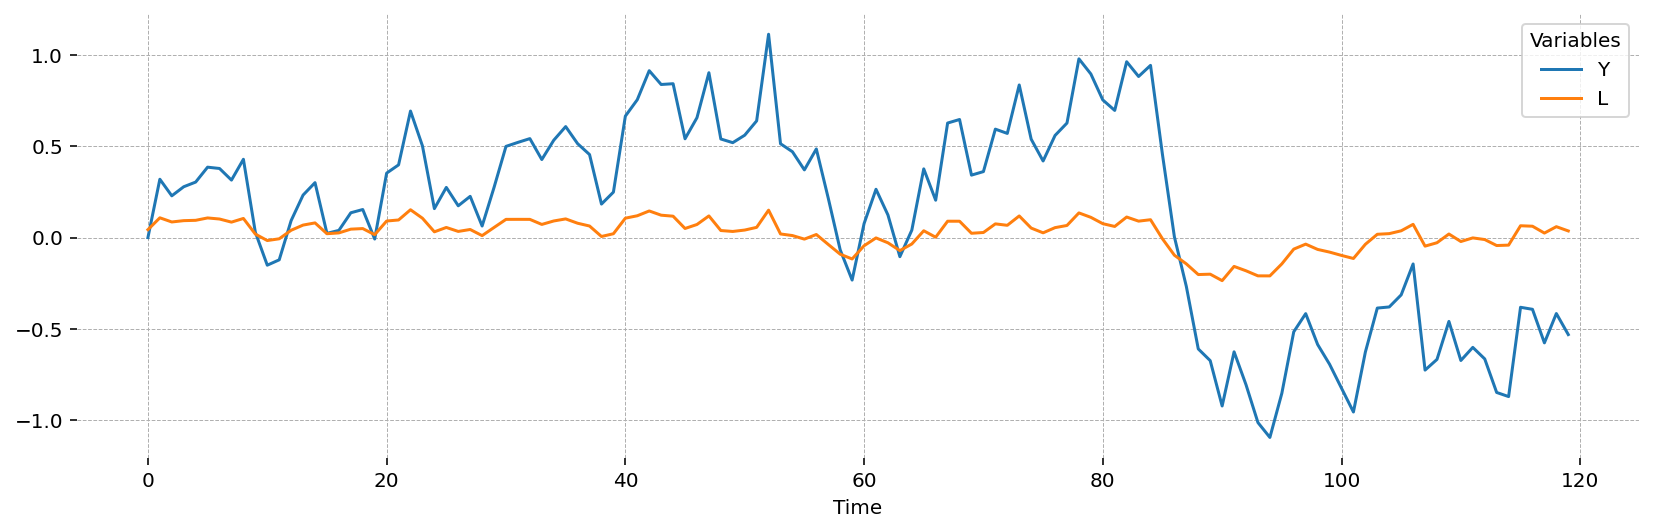

In [5]:
observed_vars = ["Y", "L"]

true_params = {
    "sigma_C": 1.35,
    "sigma_L": 2.73,
    "alpha": 0.287,
    "rho_A": 0.87,
}

true_shocks = {"epsilon_A": 0.03}

model.free_param_dict.update(true_params)
model.steady_state()
model.solve_model()

true_params.update(true_shocks)

Sigma = np.array([true_shocks["epsilon_A"]])
Sigma = np.diag(Sigma)

fake_data_all = model.simulate(
    simulation_length=120, n_simulations=1, shock_cov_matrix=Sigma
).T.droplevel(1)
fake_data = fake_data_all[observed_vars].copy()

# Add observation noise to L
fake_data["L"] = fake_data["L"] + np.random.normal(scale=0.03)

fake_data.plot();

## Priors

Priors are automatically loaded from the GCN file, but we can also add or change them at runtime. Here, we add an observation noise prior to L in order to avoid stochastic singularity.

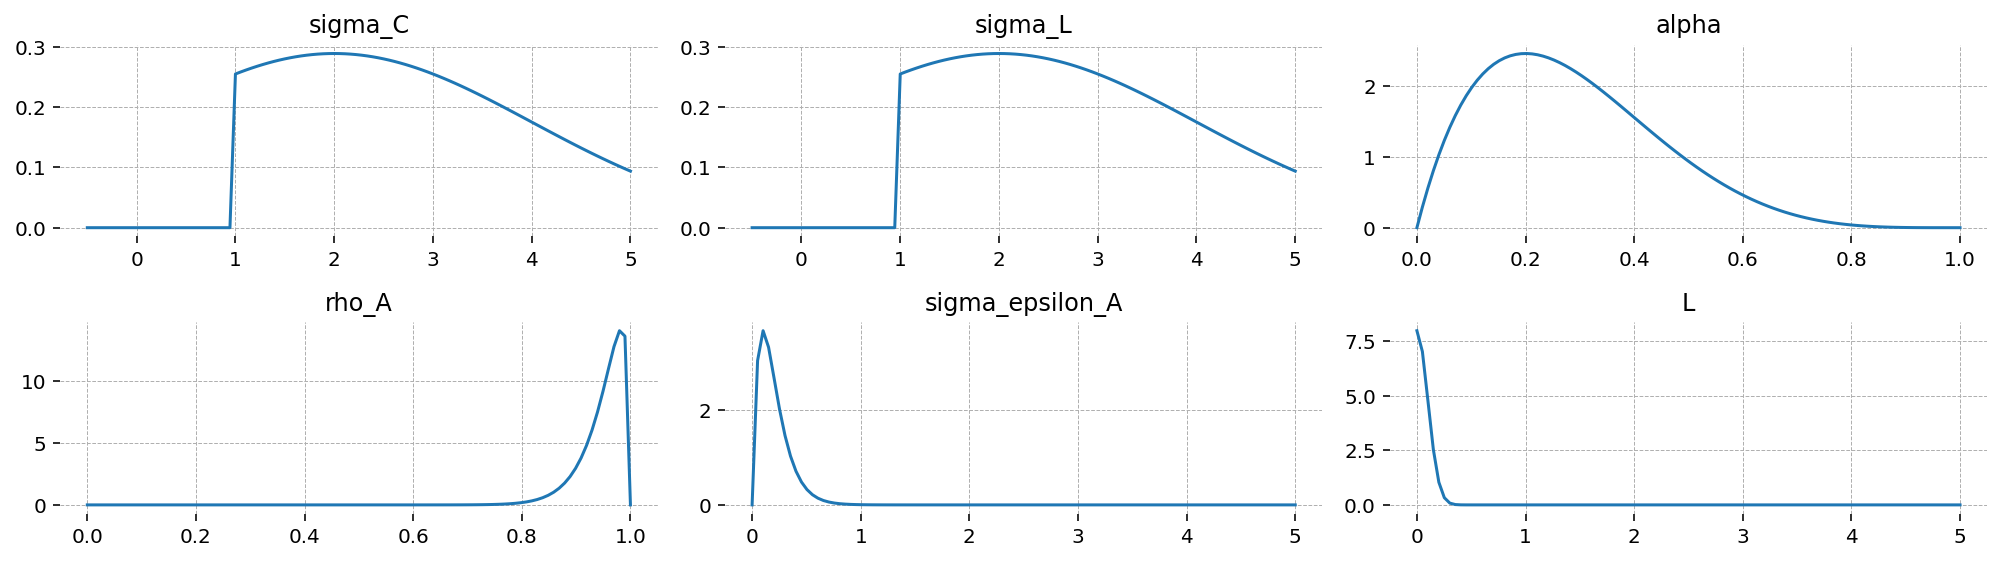

In [71]:
# To add observation noise, we need to set a prior
model.observation_noise_priors["L"] = stats.halfnorm(scale=0.1)
n_priors = len(model.param_priors) + 2
fig = plt.figure()
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=n_priors)

all_priors = model.param_priors | model.hyper_priors.to_string() | model.observation_noise_priors
for i, (k, v) in enumerate(all_priors.items()):
    d = v if not isinstance(v, tuple) else v[-1]
    a = max(-3, d.a)
    b = min(d.b, 5)
    x_grid = np.linspace(a, b, 100)
    axis = fig.add_subplot(gs[locs[i]])
    axis.plot(x_grid, d.pdf(x_grid))
    axis.set(title=k)
fig.tight_layout()

## Fit the Model!

In [72]:
idata = model.fit(
    fake_data,
    filter_type="univariate",
    draws=10_000,
    n_walkers=36,
    return_inferencedata=True,
    burn_in=1000,
)

100%|████████████████████████████████████████████████████████████████████████████| 11000/11000 [20:53<00:00,  8.78it/s]


## Emcee Sampler diagnostics

[Foreman-Mackey et al. (2014)](https://arxiv.org/abs/1202.3665), the authors of `emcee`, advocate two diagnostics to check that sampling has been successful: acceptance ratio and autocorrelation decay time. We can check both of these in the sampler object.

They suggest that an acceptance ratio between 0.2-0.6 is good, while autocorrelation decay should just be as low as possible. The important thing with autocorrelation is to make sure we get at least 100 independent samples. `emcee` will automatically show a warning after you call `model.fit()` if you did not get at least this many samples.

Acceptance fractions look good!

In [8]:
idata.sample_stats.acceptance_fraction

<xarray.DataArray 'acceptance_fraction' (chain: 36)>
array([0.36409091, 0.36954545, 0.36854545, 0.36690909, 0.36618182,
       0.36709091, 0.37218182, 0.36463636, 0.35827273, 0.36145455,
       0.37663636, 0.36836364, 0.36427273, 0.36990909, 0.36990909,
       0.37009091, 0.35763636, 0.37318182, 0.36790909, 0.36881818,
       0.36872727, 0.36072727, 0.36854545, 0.36381818, 0.36454545,
       0.37154545, 0.37154545, 0.36163636, 0.38154545, 0.35727273,
       0.37709091, 0.37109091, 0.36636364, 0.35945455, 0.37536364,
       0.37936364])
Coordinates:
  * chain    (chain) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35

We can see the sampler struggled with the standard error on `epsilon_B`, the household preference shock. 

In [9]:
idata.sample_stats.autocorrelation_time

<xarray.DataArray 'autocorrelation_time' (parameters: 6)>
array([32.80472052, 28.04911979, 28.03944481, 28.79187216, 25.75487074,
       25.65122127])
Coordinates:
  * parameters  (parameters) <U9 'sigma_C' 'sigma_L' 'alpha' ... 'epsilon_A' 'L'

## More diagnostics

In addition to the Emcee diagnostics, we can run additional checks using the `Arviz` package. First we will convert the sampler to an arviz `idata` object, giving names to the variables.

The r-hat is a common measure of chain mixing. If all the chains from our sampler converge to the same distribution, the r-hat statistic is 1.0. The higher it is, the worse the chains "mix", suggesting that the sampler failed to converge on a single distribution. We don't want to see anything above 1.05. Here our chains look OK.

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_C,1.006,0.006,1.000,1.017,0.000,0.000,11403.0,17330.0,1.0
sigma_L,2.366,0.247,1.910,2.842,0.002,0.002,12754.0,21788.0,1.0
alpha,0.150,0.019,0.114,0.187,0.000,0.000,12911.0,22902.0,1.0
rho_A,0.908,0.022,0.867,0.949,0.000,0.000,12302.0,22841.0,1.0
epsilon_A,0.033,0.004,0.026,0.040,0.000,0.000,13500.0,24805.0,1.0
L,0.001,0.000,0.001,0.001,0.000,0.000,13569.0,24819.0,1.0


The best check is always visual. We can see that everything more or less converged. The trace plots are the nice "fuzzy catterpillers", and all of the chains are exploring the same posteriors space.

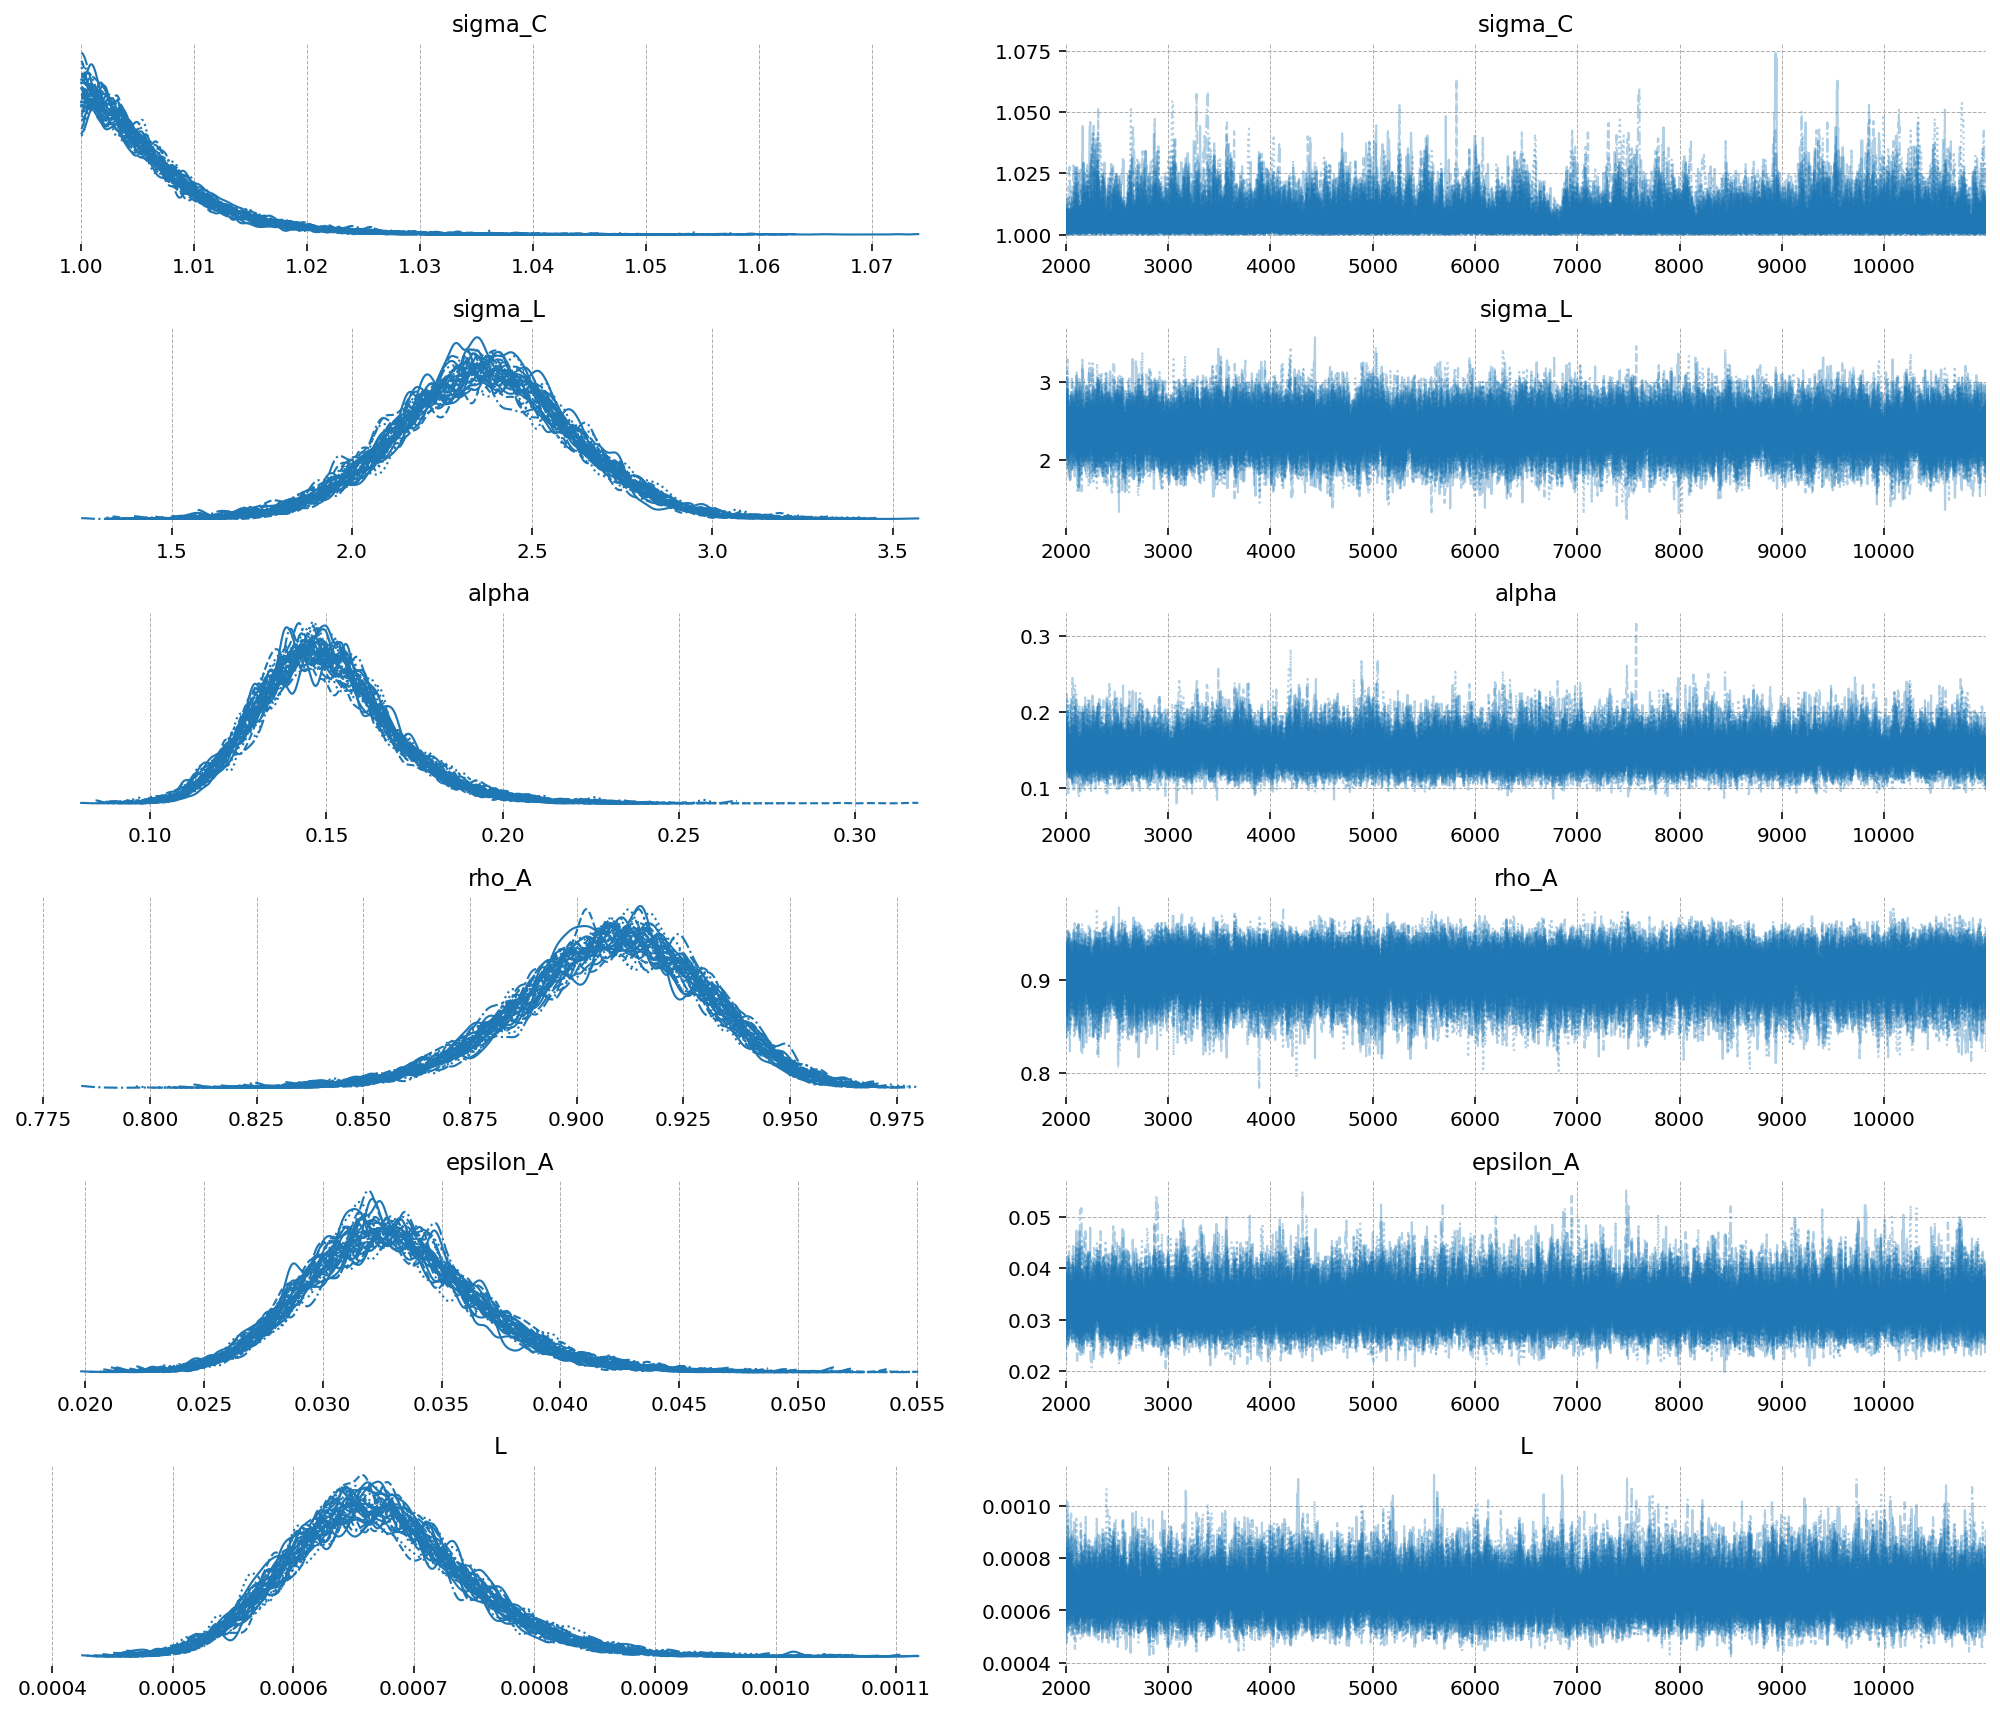

In [12]:
fig, ax = plt.subplots(6, 2, figsize=(14, 12), dpi=144)
az.plot_trace(idata.sel(draw=slice(2000, None)), axes=ax)
fig.tight_layout()
plt.show()

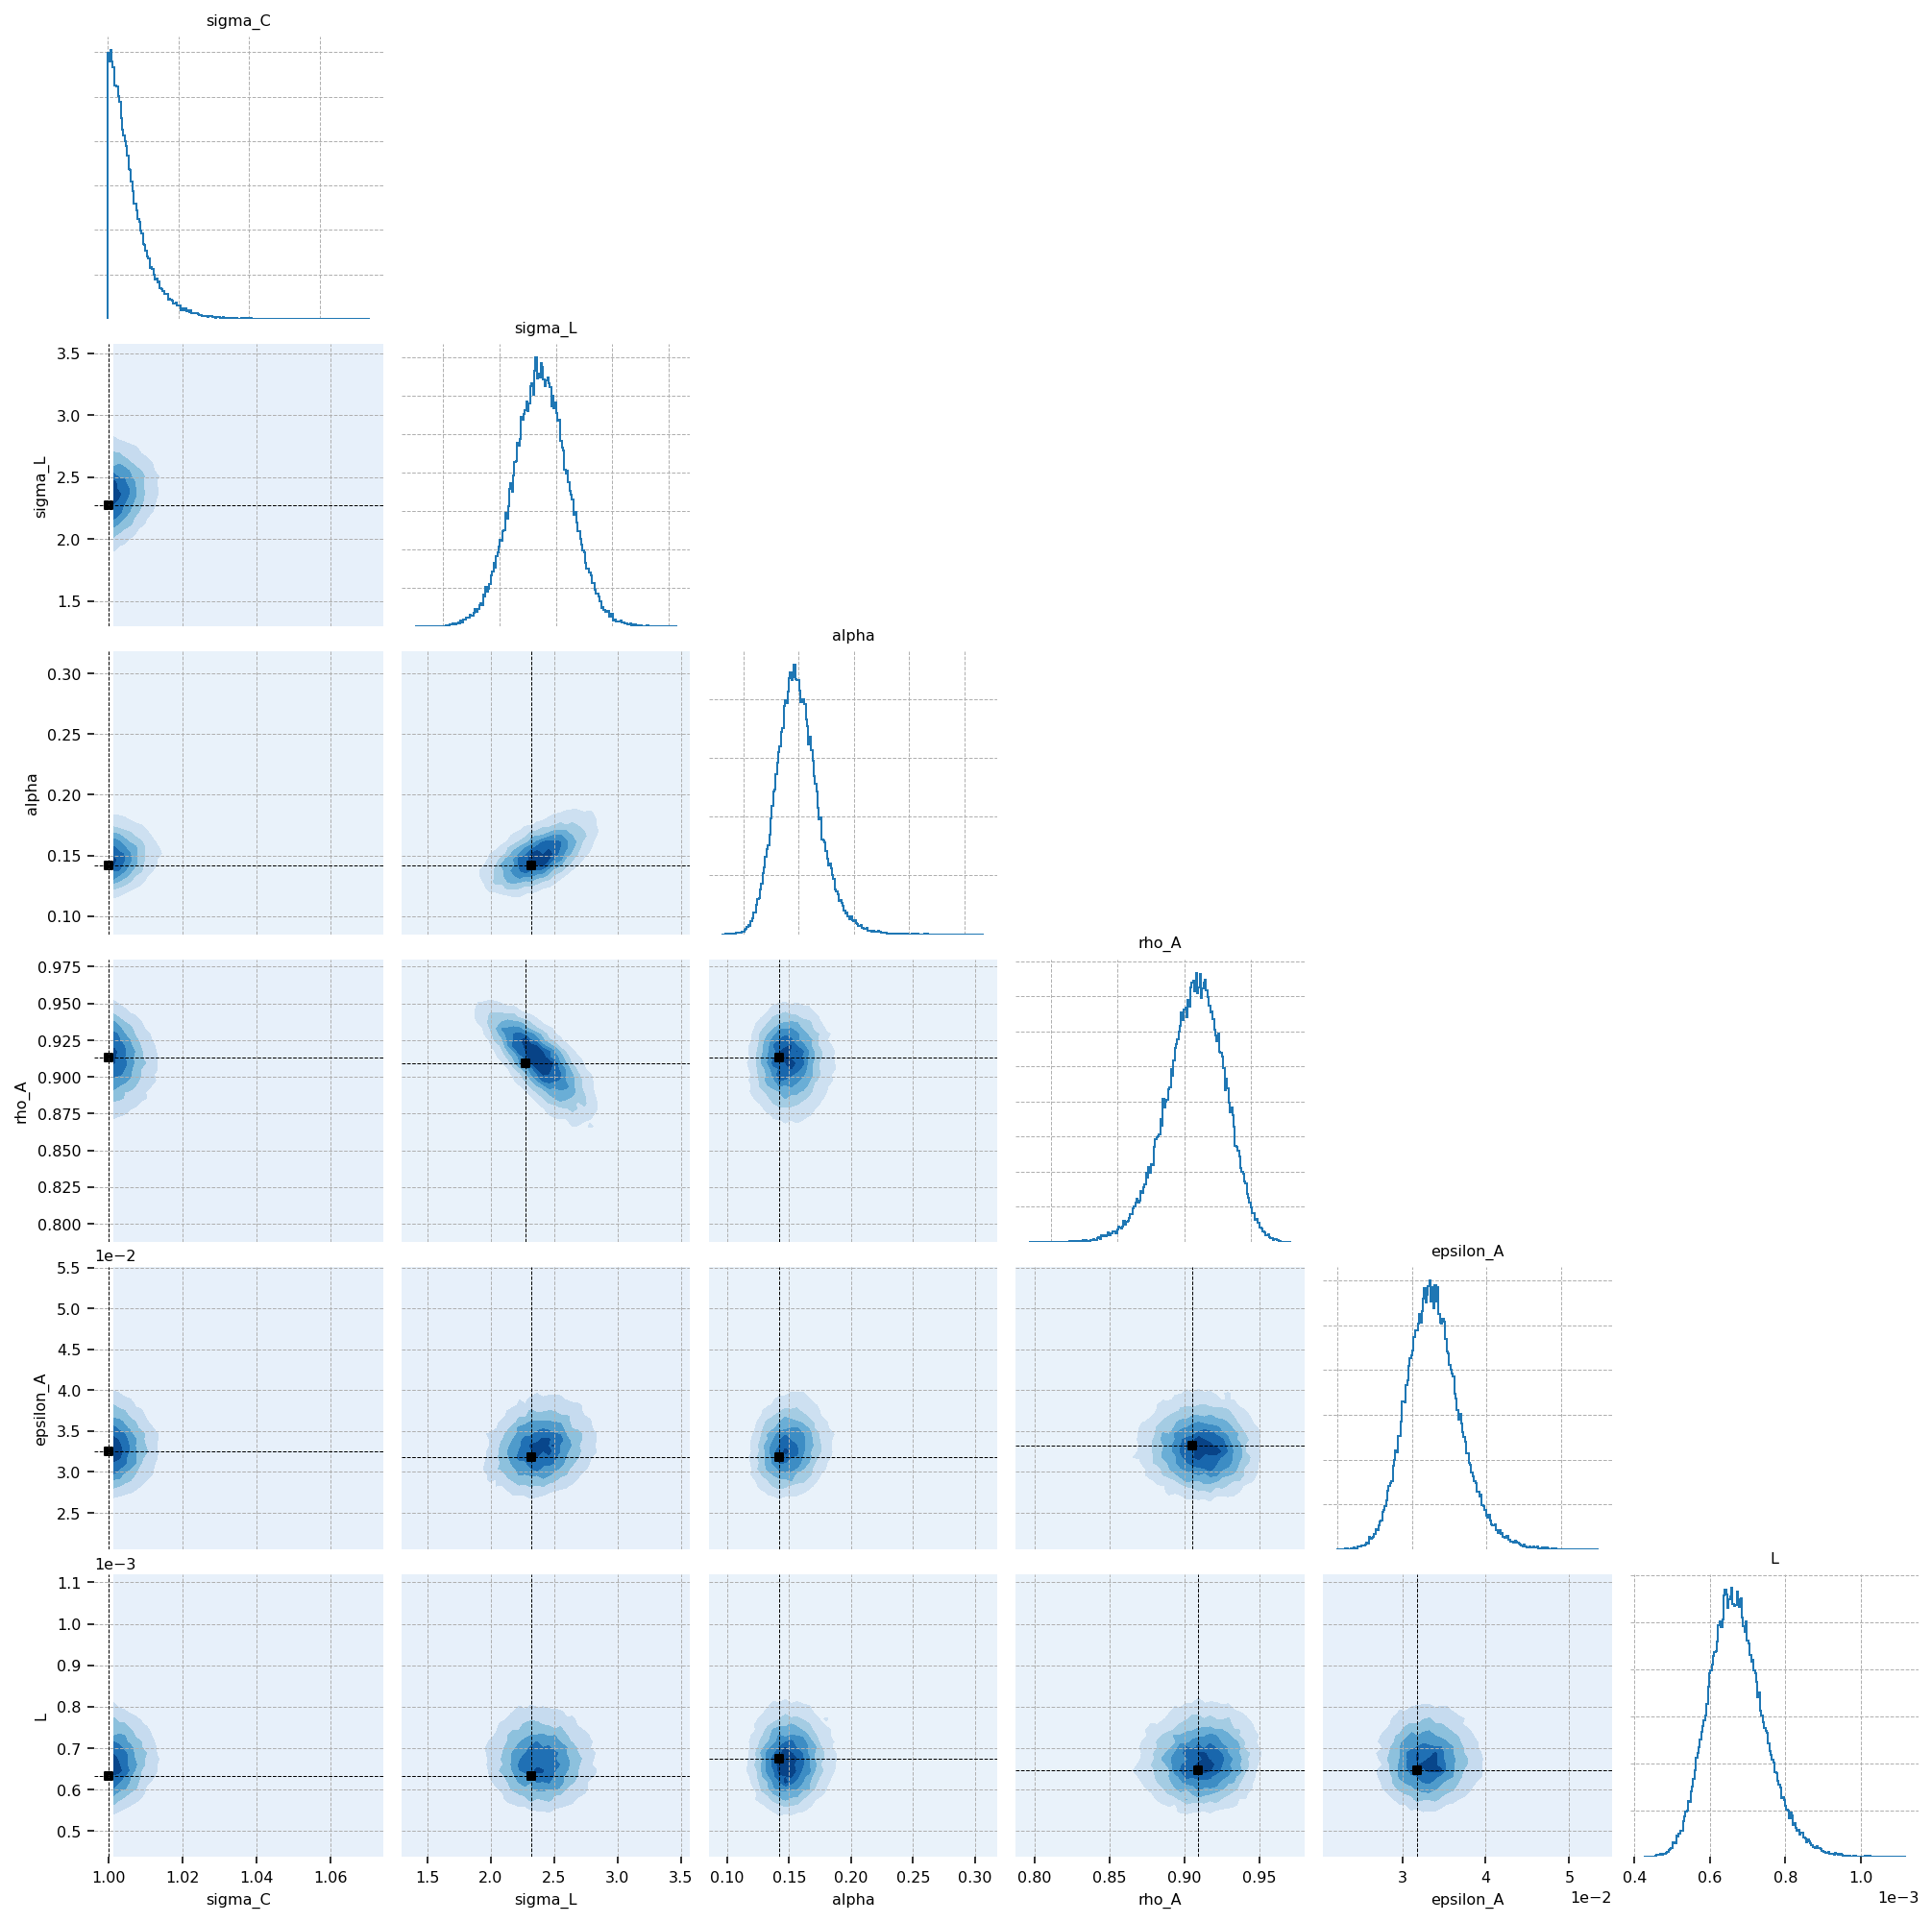

In [13]:
gp.plot_corner(idata.sel(draw=slice(2000, None)));

We can see that, in every case, the posterior has shifted the prior probability mass to be around the true parameter value.

In [52]:
prior_dict

{'sigma_C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x235408fbc40>,
 'sigma_L': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x235422e3820>,
 'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x235456cb130>,
 'rho_A': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x235456cbcd0>,
 'epsilon_A': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2354521e7c0>,
 'L': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x2357ab74d90>}

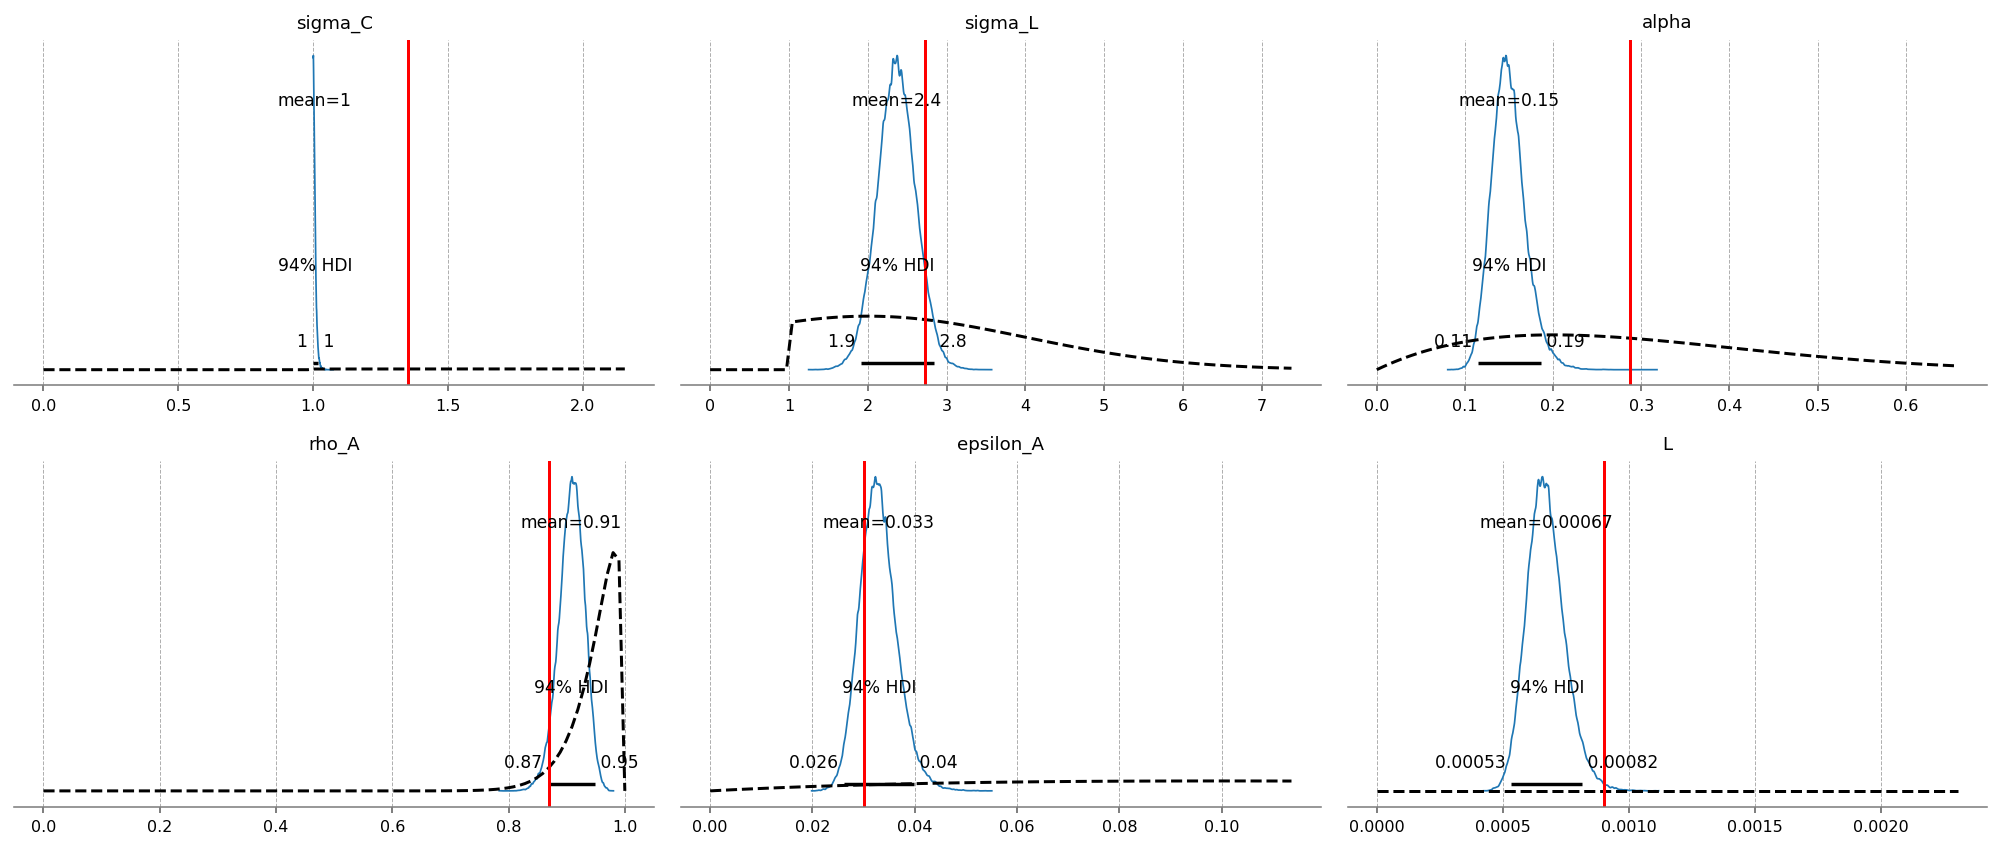

In [68]:
from gEconpy.estimation.estimation_utilities import extract_prior_dict

prior_dict = extract_prior_dict(model)
true_params.update(true_shocks)
true_params["L"] = 0.03**2

fig = plt.figure(figsize=(14, 6))
gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

for loc in plot_locs:
    axis = fig.add_subplot(gs[loc])

axes = az.plot_posterior(idata, figsize=(14, 6), textsize=8, ax=fig.axes)
for i, axis in enumerate(axes):
    param = axis.get_title()
    xmin, xmax = axis.get_xlim()
    d = prior_dict[param]
    a = max(0, d.a)
    b = min(xmax * 2, d.b)
    x_grid = np.linspace(a, b, 100)

    axis.plot(x_grid, d.pdf(x_grid), c="k", ls="--")
    axis.axvline(true_params[param], c="r")

fig.tight_layout()

## Post-Estimation 

Once we have a trace object, we can sample conditional and unconditional trajectories from the posterior

In [47]:
posterior = az.extract(idata, "posterior")
conditional_posterior = ge.sampling.kalman_filter_from_posterior(
    model, fake_data, posterior, n_samples=1000, filter_type="univariate"
)

Sampling 1000 / 1000 [==================================================] elapsed: 00:31, remaining: 00:00, 31.31iter/secr


Since the data was generated from the model, it's unsurprising that the posterior estimates for the unobserved states are centered on their true values. Still, it's reassuring that we can recover these, and it lets us know that the estimation procedure works in the ideal case.

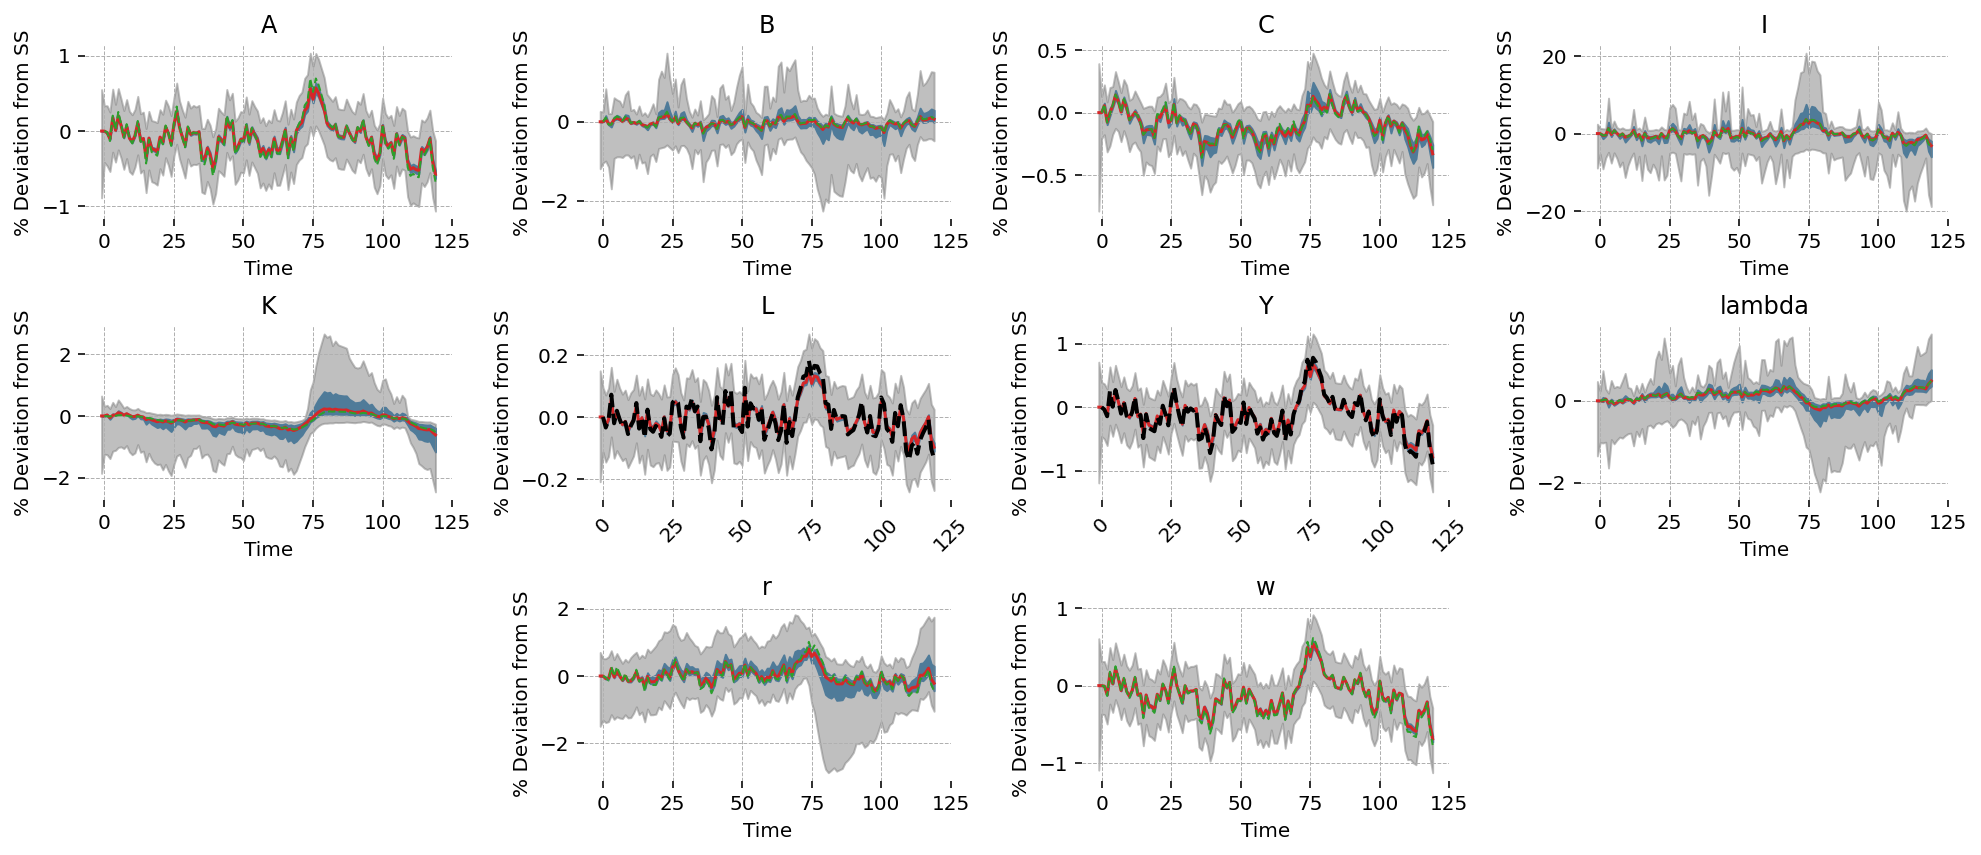

In [53]:
fig = gp.plot_kalman_filter(conditional_posterior, fake_data, kalman_output="predicted")
for axis in fig.axes:
    var_name = axis.get_title()
    if var_name not in observed_vars:
        fake_data_all[var_name].plot(ax=axis, ls="--", color="tab:green", lw=1)